# ZindiWeekendz Learning: Urban Air Pollution Challenge by #ZindiWeekendz

File name: AirAI.ipynb

Author: kogni7

Date: April 2022

## Contents
* 1 Preparation
* 2 Data
* 3 Training
* 4 Prediction and Submission

This notebook uses only the data sets provided by ZINDI. These data sets contain information about the air quality. These are the only used features in this notebook. The task is to predict the air pollution.

The file system for this project is:
* AirAI (root)
  * AirAI.ipynb (this notebook)
  * Data    
  * Submission
    * 1 - x: Submission directories named by the version number
      * submission.csv

This notebook uses a deep learning approach.

## 1 Preparation

In [1]:
versioninfo()

Julia Version 1.7.2
Commit bf53498635 (2022-02-06 15:21 UTC)
Platform Info:
  OS: Linux (x86_64-pc-linux-gnu)
  CPU: Intel(R) Core(TM) i7-7500U CPU @ 2.70GHz
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-12.0.1 (ORCJIT, skylake)


### Seed and Libraries

In [2]:
# Time
using Dates: DateTime, format, now
start_time = now()

# Seed
using Random
SEED = 42
Random.seed!(SEED);

# Printing
using Printf: @sprintf

# CSV Data Frames
using DataFrames: DataFrame, select!
using CSV: File, write

# Statistics
using StatsBase
using Statistics: mean, std

# Plotting
using Plots: plot, plot!

# Deep learning
using Flux: BatchNorm, Chain, Dense, Dropout, relu, params
using Flux.Losses: mse
using Flux.Optimise: RADAM, ADAM, update!

# Model saving
using BSON

# Cross-Validation
using MLBase: Kfold

# Machine Learning
using MLLabelUtils

println()

### Parameters

In [3]:
parameters = Dict([("Version", "2"),
                   ("nfolds", 5),
                   ("HIDDEN", [50, 100]),
                   ("DROPOUT", [0.0, 0.1]),
                   ("BATCH", 32),
                   ("EPOCHS", 15),
                   ("OPTIMIZER", [ADAM(0.001, (0.9, 0.999)), RADAM(0.001, (0.9, 0.8))]),
                   ("WEIGHT", [0.2, 0.2, 0.2, 0.2, 0.2])
                  ])

println()

## 2 Data

In [4]:
Train_csv = DataFrame(File("./Data/Train.csv"))
Test_csv = DataFrame(File("./Data/Test.csv"))
SampleSubmission_csv = DataFrame(File("./Data/SampleSubmission.csv"))
println()

┌ Warning: thread = 1 warning: only found 19 / 82 columns around data row: 30557. Filling remaining columns with `missing`
└ @ CSV /home/andreas/.julia/packages/CSV/jFiCn/src/file.jl:578


In [5]:
first(Train_csv, 3)

,Place_ID X Date,Date,Place_ID,target,target_min,target_max,target_variance
,String31,Date,String7,Float64,Float64,Float64,Float64
1,010Q650 X 2020-01-02,2020-01-02,010Q650,38.0,23.0,53.0,769.5
2,010Q650 X 2020-01-03,2020-01-03,010Q650,39.0,25.0,63.0,1319.85
3,010Q650 X 2020-01-04,2020-01-04,010Q650,24.0,8.0,56.0,1181.96


In [6]:
first(Test_csv, 3)

,Place_ID X Date,Date,Place_ID,precipitable_water_entire_atmosphere
,String31,Date,String7,Float64
1,0OS9LVX X 2020-01-02,2020-01-02,0OS9LVX,11.6
2,0OS9LVX X 2020-01-03,2020-01-03,0OS9LVX,18.3
3,0OS9LVX X 2020-01-04,2020-01-04,0OS9LVX,17.6


In [7]:
first(SampleSubmission_csv, 3)

,Place_ID X Date,target
,String31,Int64
1,0OS9LVX X 2020-01-02,0
2,0OS9LVX X 2020-01-03,0
3,0OS9LVX X 2020-01-04,0


### Label encoding

In [8]:
Train_csv.Date = convertlabel(LabelEnc.Indices, Train_csv.Date)
Train_csv.Place_ID = convertlabel(LabelEnc.Indices, Train_csv.Place_ID)

Test_csv.Date = convertlabel(LabelEnc.Indices, Test_csv.Date)
Test_csv.Place_ID = convertlabel(LabelEnc.Indices, Test_csv.Place_ID)
println()

### Imputing

In [9]:
using MLJ
@load FillImputer
imputer = machine(FillImputer(), Train_csv)
fit!(imputer)
X = MLJ.transform(imputer, Train_csv)
println()

import MLJModels ✔



┌ Info: For silent loading, specify `verbosity=0`. 
└ @ Main /home/andreas/.julia/packages/MLJModels/OYpZv/src/loading.jl:168
┌ Info: Training Machine{FillImputer,…}.
└ @ MLJBase /home/andreas/.julia/packages/MLJBase/rMXo2/src/machines.jl:423


In [10]:
using DataFrames
labels = X[1:end, 4]
select!(X, Not(["target", "target_min", "target_max", "target_variance", "target_count"]))
features = Matrix(X[1:end, 2:end])
println()

In [11]:
using MLJ
@load FillImputer
imputer = machine(FillImputer(), Test_csv)
fit!(imputer)
X_test = MLJ.transform(imputer, Test_csv)
test_features = Matrix(X_test[1:end, 2:end])
println()

import MLJModels ✔



┌ Info: For silent loading, specify `verbosity=0`. 
└ @ Main /home/andreas/.julia/packages/MLJModels/OYpZv/src/loading.jl:168
┌ Info: Training Machine{FillImputer,…}.
└ @ MLJBase /home/andreas/.julia/packages/MLJBase/rMXo2/src/machines.jl:423


### Standardization

In [12]:
using StatsBase

dt = fit(ZScoreTransform, features, dims=1)
features = StatsBase.transform(dt, features)

dt = fit(ZScoreTransform, test_features, dims=1)
test_features = StatsBase.transform(dt, test_features)

println()

In [13]:
features

30557×76 Matrix{Float64}:
 -1.71356   -1.72998  -0.402516   …   3.65807   -1.07199    1.28968
 -1.67669   -1.72998  -0.0657081      5.56239   -0.89113    1.05885
 -1.63983   -1.72998   0.102696      -0.275333   0.286273  -0.310853
 -1.60296   -1.72998  -0.784986      -0.275333   0.286273  -0.310853
 -1.5661    -1.72998  -0.131199      -0.275333   0.286273  -0.310853
 -1.52923   -1.72998  -0.0657081  …  -0.275333   0.286273  -0.310853
 -1.49236   -1.72998   0.0278498     -0.275333   0.286273  -0.310853
 -1.4555    -1.72998   0.308523      -0.275333   0.286273  -0.310853
 -1.41863   -1.72998  -0.32767       -0.275333   0.286273  -0.310853
 -1.38177   -1.72998  -0.459012      -0.275333   0.286273  -0.310853
 -1.3449    -1.72998  -0.290247   …  -0.275333   0.286273  -0.310853
 -1.30804   -1.72998  -0.159266      -0.275333   0.286273  -0.310853
 -1.27117   -1.72998  -0.26218       -0.275333   0.286273  -0.310853
  ⋮                               ⋱                         ⋮
  0.719585   1.73

In [14]:
labels

30557-element Vector{Float64}:
  38.0
  39.0
  24.0
  49.0
  21.0
  28.0
  21.0
  18.0
  21.0
  24.0
  31.0
  25.0
  29.0
   ⋮
  56.0
  94.0
  89.0
  63.0
  56.0
  45.0
  22.0
  22.0
  53.0
  85.0
 103.0
  89.0

In [15]:
test_features

16136×76 Matrix{Float64}:
 -1.72331  -1.7208   -0.277494   …  -0.258249   0.289119  -0.0529081
 -1.68643  -1.7208    0.437016      -0.258249   0.289119  -0.0529081
 -1.64955  -1.7208    0.362366      -0.258249   0.289119  -0.0529081
 -1.61267  -1.7208    0.0863673     -0.258249   0.289119  -0.0529081
 -1.57579  -1.7208   -0.480116       4.05025   -1.72583    0.616492
 -1.53891  -1.7208   -0.085536   …   0.836239  -1.69584    0.214161
 -1.50203  -1.7208   -0.757388      -0.258249   0.289119  -0.0529081
 -1.46515  -1.7208   -0.501445       4.85578   -1.63767   -0.575202
 -1.42827  -1.7208   -0.618752      -0.258249   0.289119  -0.0529081
 -1.39139  -1.7208   -0.405877      -0.422669   0.289119  -1.95294
 -1.35451  -1.7208   -0.373473   …  -0.422669   0.289119  -1.95294
 -1.31763  -1.7208   -0.586759      -0.422669   0.289119  -1.95294
 -1.28075  -1.7208   -0.394801      -0.422669   0.289119  -1.95294
  ⋮                              ⋱                         ⋮
  1.30089   1.70317   0.426

## 3 Training

In [16]:
function return_model(p)
    return Chain(Dense(76, p["HIDDEN"]),
                 Dropout(p["DROPOUT"]),
                 BatchNorm(p["HIDDEN"], relu),      
                 Dense(p["HIDDEN"], p["HIDDEN"]),
                 Dropout(p["DROPOUT"]),
                 BatchNorm(p["HIDDEN"], relu),
                 Dense(p["HIDDEN"], 1, relu))
end


function plotting(losses, title, CV)
    plot(losses[:,1],
         title = string("Loss ", title),
         xlabel = "epoch",
         ylabel = "loss",
         label = "fold_1",
         lw = 3)
    for i in 2:CV-1
        label = @sprintf "fold_%i" i
        plot!(losses[:,i],
              label = label,
              lw = 3)
    end
    label = @sprintf "fold_%i" CV
    plot_losses = plot!(losses[:,CV],
                        label = label,
                        lw = 3)
    plot(plot_losses, layout = (2, 1), size = (500, 200))
end


function summary(train_losses, val_losses, version)
    println()
    println(version)
    println("Epoch \t Loss TRAINING \t \t Loss VALIDATION")
    println("===================================================")
    for i in 1:size(train_losses)[1]
        string = @sprintf "%i: \t %5.3f (SD: %5.3f) \t %5.3f (SD: %5.3f)" i mean(train_losses[i,:]) std(train_losses[i,:]) mean(val_losses[i,:]) std(val_losses[i,:]);
        println(string)
    end
end


using Flux

function training(features, labels, p, version)
    """
    This function is a cross-validated training.
    """
    #println("Cross-Validated Training is starting...")

    TRAIN_LOSSES = zeros(p["EPOCHS"], p["nfolds"])
    VAL_LOSSES = zeros(p["EPOCHS"], p["nfolds"])

    folds = collect(Kfold(size(features)[2], p["nfolds"]))

    for i in 1:p["nfolds"]
        #time_1 = now()
        #s = @sprintf "Fold: %i" i;
        #println(s)

        # Data
        X_train = features[:, folds[i]]
        X_val = features[:, setdiff(Vector(1:size(features)[2]), folds[i])]
        y_train = labels[folds[i]]
        y_val = labels[setdiff(Vector(1:size(labels)[1]), folds[i])] 

        dataloader_train = Flux.Data.DataLoader((X_train, y_train),
                                                batchsize=p["BATCH"],
                                                shuffle=true,
                                                partial=false)
        dataloader_val = Flux.Data.DataLoader((X_val, y_val),
                                              batchsize=p["BATCH"],
                                              partial=false)

        # Model
        model = nothing
        model = return_model(p)
        ps = params(model)
        loss(x, y) = mse(vec(model(x)), y)    
        opt = p["OPTIMIZER"]

        best_RMSE = Inf
        for e in 1:p["EPOCHS"]
            t_l = []
            v_l = []

            for d in dataloader_train
                grad = gradient(()->loss(d[1], d[2]), ps)
                update!(opt, ps, grad)
                push!(t_l, sqrt(loss(d[1], d[2])))                
            end

            for d in dataloader_val
                push!(v_l, sqrt(loss(d[1], d[2])))
            end

            TRAIN_LOSSES[e, i] = mean(t_l)
            VAL_LOSSES[e, i] = mean(v_l)

            if VAL_LOSSES[e, i] <= best_RMSE
                BSON.@save string("./Submission/model_", p["Version"], "_", string(i), ".bson") model
                best_RMSE = VAL_LOSSES[e, i]
            end
        end

        #time_2 = now()
        #duration_fold = format(convert(DateTime, time_2 - time_1), "MM:SS")
        #println(string("Duration of fold: ", duration_fold))
    end

    summary(TRAIN_LOSSES, VAL_LOSSES, p["Version"])
    display(plotting(TRAIN_LOSSES, string("TRAINING ", p["Version"]), p["nfolds"]))
    display(plotting(VAL_LOSSES, string("VALIDATION ", p["Version"]), p["nfolds"]))
end


function predict(test_features, p)
    predictions = zeros(1, size(test_features)[1])

    for i in 1:parameters["nfolds"]
        BSON.@load string("./Submission/model_", p["Version"], "_", string(i), ".bson") model

        b_1 = 1
        b_2 = 8

        actual_prediction = nothing

        for b in 1:(size(test_features)[1]/8)
            x = model(transpose(test_features[b_1:b_2, 1:end]))
            if b == 1
                actual_prediction = x
            else
                actual_prediction = hcat(actual_prediction, x)
            end
            b_1 += 8
            b_2 += 8
        end
        predictions .+= p["WEIGHT"][i] * actual_prediction
        rm(string("./Submission/model_", p["Version"], "_", string(i), ".bson"))
    end

    SampleSubmission_csv.target = vec(predictions)
    mkdir(string("./Submission/", p["Version"]))
    write(string("./Submission/", p["Version"], "/submission.csv"), SampleSubmission_csv)
end
println()

In [17]:
function grid(para)
    i = 1
    println("Version HIDDEN DROPOUT OPTIMIZER")
    println("================================")
    for h in para["HIDDEN"]
        for d in para["DROPOUT"]
            for o in 1:length(para["OPTIMIZER"])
                string = @sprintf "%s_%i \t %i \t %1.1f \t %i" para["Version"] i h d o;
                println(string)
                i += 1
            end
        end
    end
end


function grid_search(features, labels, para)
    i = 1
    for h in para["HIDDEN"]
        for d in para["DROPOUT"]
            for o in para["OPTIMIZER"]
                p = Dict([("Version", string(para["Version"], "_", i)),
                          ("nfolds", para["nfolds"]),
                          ("HIDDEN", h),
                          ("DROPOUT", d),
                          ("BATCH", para["BATCH"]),
                          ("EPOCHS", para["EPOCHS"]),
                          ("OPTIMIZER", o),
                          ("WEIGHT", para["WEIGHT"])
                        ])
                #println(string("Version ", i))
                training(transpose(features), labels, p, i)
                i += 1
            end
        end
    end
    return i
end


function predict_all(test_features, para, number_models)
    for i in 1:number_models-1
        p = Dict([("Version", string(para["Version"], "_", i)),
                  ("nfolds", para["nfolds"]),
                  ("WEIGHT", para["WEIGHT"])
                 ])
        predict(test_features, p)
    end
end
   
println()

### Train!

In [18]:
grid(parameters)

Version HIDDEN DROPOUT OPTIMIZER
2_1 	 50 	 0.0 	 1
2_2 	 50 	 0.0 	 2
2_3 	 50 	 0.1 	 1
2_4 	 50 	 0.1 	 2
2_5 	 100 	 0.0 	 1
2_6 	 100 	 0.0 	 2
2_7 	 100 	 0.1 	 1
2_8 	 100 	 0.1 	 2


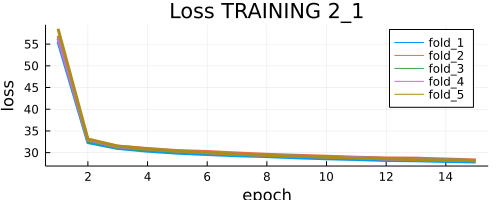

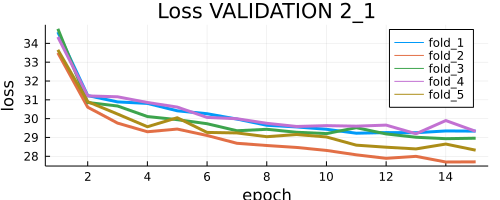

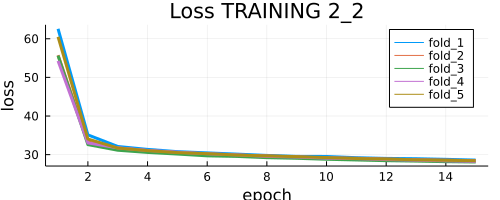

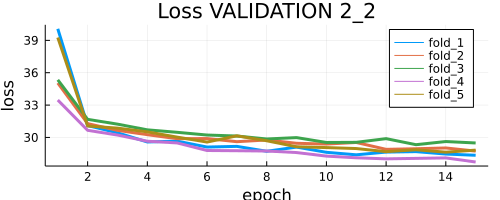

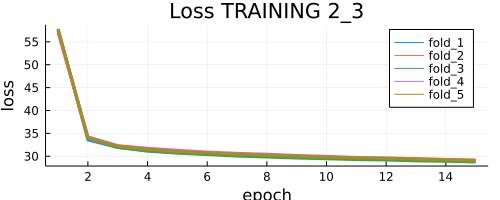

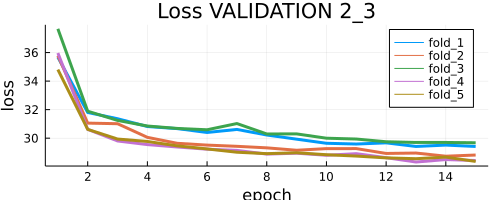

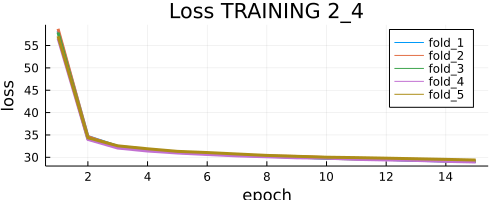

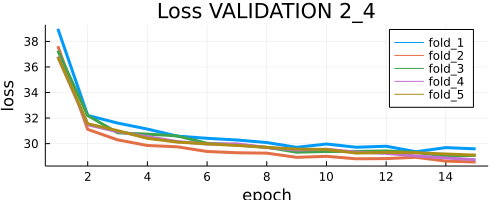

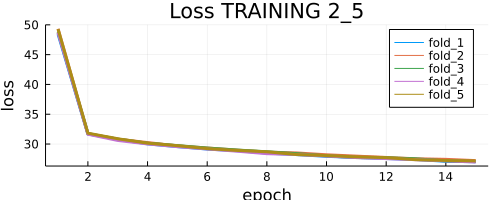

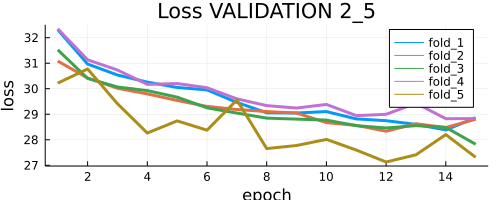

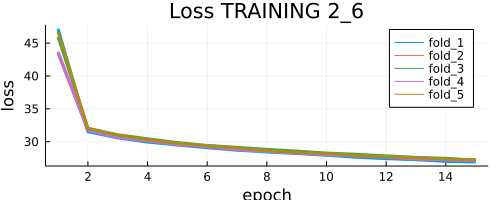

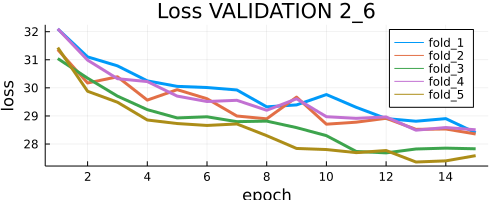

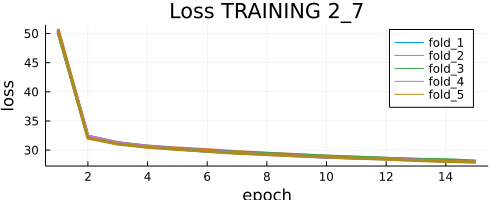

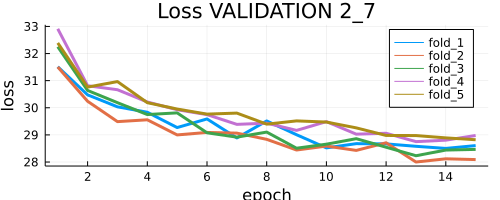

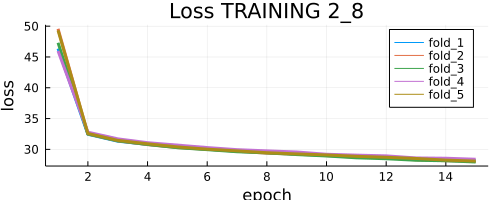

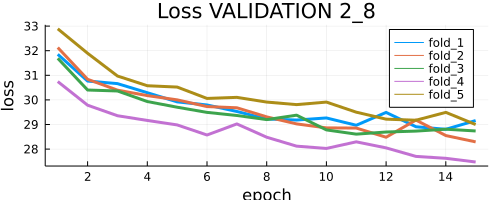


2_1
Epoch 	 Loss TRAINING 	 	 Loss VALIDATION
1: 	 56.721 (SD: 1.127) 	 34.173 (SD: 0.569)
2: 	 32.769 (SD: 0.307) 	 30.960 (SD: 0.260)
3: 	 31.287 (SD: 0.243) 	 30.546 (SD: 0.552)
4: 	 30.722 (SD: 0.243) 	 30.131 (SD: 0.705)
5: 	 30.268 (SD: 0.232) 	 30.094 (SD: 0.452)
6: 	 29.955 (SD: 0.248) 	 29.686 (SD: 0.497)
7: 	 29.618 (SD: 0.224) 	 29.452 (SD: 0.549)
8: 	 29.390 (SD: 0.188) 	 29.289 (SD: 0.485)
9: 	 29.155 (SD: 0.208) 	 29.209 (SD: 0.452)
10: 	 28.948 (SD: 0.217) 	 29.121 (SD: 0.507)
11: 	 28.753 (SD: 0.199) 	 29.003 (SD: 0.652)
12: 	 28.553 (SD: 0.216) 	 28.895 (SD: 0.703)
13: 	 28.434 (SD: 0.219) 	 28.770 (SD: 0.551)
14: 	 28.290 (SD: 0.200) 	 28.905 (SD: 0.823)
15: 	 28.123 (SD: 0.175) 	 28.730 (SD: 0.706)

2_2
Epoch 	 Loss TRAINING 	 	 Loss VALIDATION
1: 	 57.747 (SD: 3.584) 	 36.636 (SD: 2.870)
2: 	 33.621 (SD: 0.990) 	 31.156 (SD: 0.369)
3: 	 31.692 (SD: 0.349) 	 30.681 (SD: 0.391)
4: 	 31.022 (SD: 0.284) 	 30.141 (SD: 0.507)
5: 	 30.528 (SD: 0.232) 	 29.907 (SD: 0.379)


In [19]:
number_models = grid_search(features, labels, parameters)
println()

## 4 Prediction and Submission

In [20]:
predict_all(test_features, parameters, number_models)

In [21]:
end_time = now()
duration = format(convert(DateTime, end_time - start_time), "MM:SS")
println(string("Duration: ", duration))

Duration: 25:27
